In [2]:
Q = np.array([
    [-1.0, 0.0],
    [0.0, 0.0],
    [1.0, 2.0],
    [3.0, 3.0],
    [4.0, 0.0],
])  # 4 knots => n=3 Bezier segments

In [47]:
Q = np.array([
    [-1.0, 0.0],
    [0.0, 0.0],
    [1.0, 0.0],
    [1.0, 1.0],
    [0.0, 2.0],
    [0.0, 3.0],
    [0.0, 4.0],
    #[-1.0, 1.0],
    #[0.0, 0.0], ... Closed system => done set endpoint
])  # 4 knots => n=3 Bezier segments

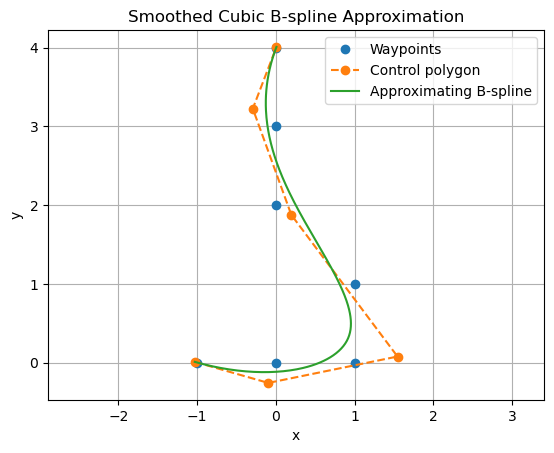

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Smoothed B-spline approximation (cubic)
# -----------------------

# Waypoints
# Q = np.array([
#     [0.0, 0.0],
#     [1.0, 2.0],
#     [3.0, 3.0],
#     [4.0, 2.0],
#     [5.0, 0.0]
# ])

M = len(Q) - 1
k = 3 #3  # cubic degree

# Step 1: chord-length parameters in [0,1]
dist = np.linalg.norm(np.diff(Q, axis=0), axis=1)
t = np.zeros(M + 1)
t[1:] = np.cumsum(dist)
t /= t[-1]

# Step 2: fewer control points => approximation not interpolation
n = 5 #4  # n+1 control points

# Step 3: clamped uniform knot vector on [0,1]
U = np.zeros(n + k + 2)
U[-(k+1):] = 1.0
num_interior = n - k
if num_interior > 0:
    interior = np.linspace(0, 1, num_interior + 2)[1:-1]
    U[k+1:k+1+num_interior] = interior

# Cox–de Boor basis with endpoint handling
def N(i, p, x):
    if p == 0:
        # include right endpoint so curve reaches the end
        if (U[i] <= x < U[i+1]) or (x == U[-1] and U[i] <= x <= U[i+1]):
            return 1.0
        return 0.0

    denom1 = U[i+p] - U[i]
    denom2 = U[i+p+1] - U[i+1]
    term1 = 0.0
    term2 = 0.0
    if denom1 > 1e-12:
        term1 = (x - U[i]) / denom1 * N(i, p-1, x)
    if denom2 > 1e-12:
        term2 = (U[i+p+1] - x) / denom2 * N(i+1, p-1, x)
    return term1 + term2

# Step 4: build basis matrix A
A = np.zeros((M + 1, n + 1))
for j in range(M + 1):
    for i in range(n + 1):
        A[j, i] = N(i, k, t[j])

# Step 5: smoothing penalty on 2nd differences
lam = 1e-2 #1e-2
D2 = np.zeros((n - 1, n + 1))
for i in range(n - 1):
    D2[i, i]     = 1.0
    D2[i, i + 1] = -2.0
    D2[i, i + 2] = 1.0

# Solve (A^T A + lam D^T D) P = A^T Q
P = np.linalg.solve(A.T @ A + lam * (D2.T @ D2), A.T @ Q)

# Evaluate spline
T = np.linspace(0, 1, 300)
curve = np.zeros((len(T), 2))
for ti, tt in enumerate(T):
    for i in range(n + 1):
        curve[ti] += N(i, k, tt) * P[i]

# Plot
plt.figure()
plt.plot(Q[:, 0], Q[:, 1], 'o', label="Waypoints")
plt.plot(P[:, 0], P[:, 1], '--o', label="Control polygon")
plt.plot(curve[:, 0], curve[:, 1], label="Approximating B-spline")
plt.title("Smoothed Cubic B-spline Approximation")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()


In [19]:
print(U)

[0.   0.   0.   0.   0.25 0.5  0.75 1.   1.   1.   1.  ]


In [26]:
M

6

In [37]:
Q = np.array([
    [0.0, 0.0],
    [1.0, 0.0],
    [1.0, 1.0],
    [0.0, 2.0],
    [-1.0, 1.0],
    #[-0.75, 0.5],
    #[-0.25, 0.75],
    #[0.0, 0.0],
])

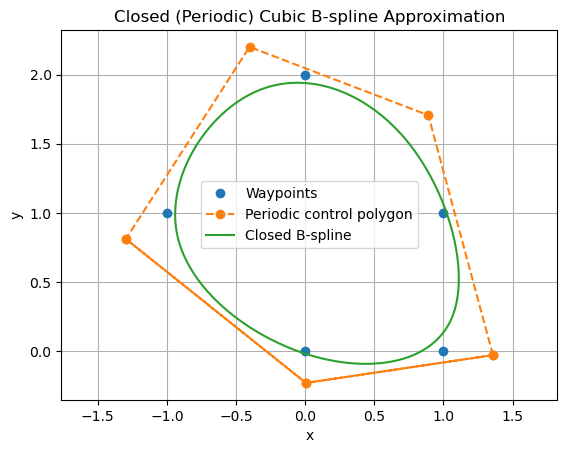

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Closed (periodic) cubic B-spline approximation
# -----------------------

# Example closed-loop waypoints (replace with yours)
# Q = np.array([
#     [0.0, 0.0],
#     [1.5, 2.0],
#     [3.5, 2.5],
#     [5.0, 0.5],
#     [4.0, -2.0],
#     [2.0, -2.5],
#     [0.5, -1.5]
# ])

# Ensure closed data (append first point if needed)
if np.linalg.norm(Q[0] - Q[-1]) > 1e-9:
    Q = np.vstack([Q, Q[0]])

M = len(Q) - 1  # last equals first
k = 3           # cubic

# Step 1: chord-length parameters around the loop, normalized to [0,1)
dist = np.linalg.norm(np.diff(Q, axis=0), axis=1)
s = np.zeros(M + 1)
s[1:] = np.cumsum(dist)
t = s / s[-1]
t = t[:-1]      # drop duplicated last point; t in [0,1)

Q_data = Q[:-1]

# Step 2: choose number of control points (more = closer fit)
Ncp = 8
assert Ncp > k

# Periodicity constraint: last k control points are copies of first k
Nind = Ncp - k   # independent control points

# Step 3: uniform *non-clamped* knot vector
U = np.arange(Ncp + k + 2, dtype=float)

# Parameter domain for basis is [U[k], U[Ncp]]
t_eval = U[k] + t * (U[Ncp] - U[k])

# Cox–de Boor basis
def N(i, p, x):
    if p == 0:
        return 1.0 if (U[i] <= x < U[i+1]) else 0.0
    denom1 = U[i+p] - U[i]
    denom2 = U[i+p+1] - U[i+1]
    term1 = 0.0
    term2 = 0.0
    if denom1 > 1e-12:
        term1 = (x - U[i]) / denom1 * N(i, p-1, x)
    if denom2 > 1e-12:
        term2 = (U[i+p+1] - x) / denom2 * N(i+1, p-1, x)
    return term1 + term2

# Step 4: Build full basis matrix A for all Ncp control points
A_full = np.zeros((len(t_eval), Ncp))
for j, tj in enumerate(t_eval):
    for i in range(Ncp):
        A_full[j, i] = N(i, k, tj)

# Merge tied columns -> matrix for independent control points
A_hat = A_full[:, :Nind].copy()
for j in range(k):
    A_hat[:, j] += A_full[:, Nind + j]

# Step 5: cyclic smoothing penalty (second differences, wrap-around)
lam = 1e-2
D2 = np.zeros((Nind, Nind))
for i in range(Nind):
    D2[i, i] = 1.0
    D2[i, (i+1) % Nind] = -2.0
    D2[i, (i+2) % Nind] = 1.0

# Solve regularized least squares
P_ind = np.linalg.solve(
    A_hat.T @ A_hat + lam * (D2.T @ D2),
    A_hat.T @ Q_data
)

# Reconstruct full periodic control points
P = np.vstack([P_ind, P_ind[:k]])

# Evaluate spline densely (endpoint=False keeps it periodic)
T = np.linspace(U[k], U[Ncp], 400, endpoint=False)
curve = np.zeros((len(T), 2))
for ti, tt in enumerate(T):
    for i in range(Ncp):
        curve[ti] += N(i, k, tt) * P[i]

# Plot
plt.figure()
plt.plot(Q_data[:, 0], Q_data[:, 1], 'o', label="Waypoints")
plt.plot(P[:, 0], P[:, 1], '--o', label="Periodic control polygon")
plt.plot(curve[:, 0], curve[:, 1], label="Closed B-spline")
plt.axis('equal')
plt.title("Closed (Periodic) Cubic B-spline Approximation")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.show()


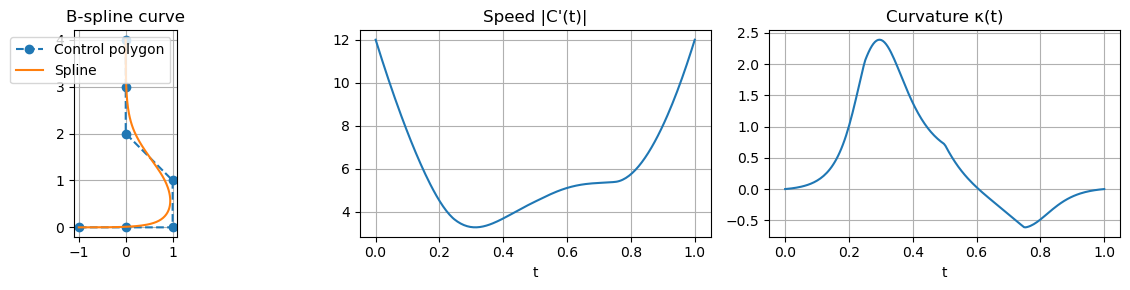

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# B-spline basis and evaluation
# -------------------------------

# def bspline_basis(i, k, t, knots):
#     """Cox–de Boor recursion for scalar t."""
#     if k == 0:
#         return 1.0 if (knots[i] <= t < knots[i+1]) else 0.0
#     denom1 = knots[i+k]   - knots[i]
#     denom2 = knots[i+k+1] - knots[i+1]
#     term1 = 0.0
#     term2 = 0.0
#     if denom1 > 1e-14:
#         term1 = (t - knots[i]) / denom1 * bspline_basis(i, k-1, t, knots)
#     if denom2 > 1e-14:
#         term2 = (knots[i+k+1] - t) / denom2 * bspline_basis(i+1, k-1, t, knots)
#     return term1 + term2

def bspline_basis(i, k, t, knots):
    """Cox–de Boor recursion for scalar t (fixed endpoint handling)."""
    if k == 0:
        # Include the right endpoint in the last knot span
        if (knots[i] <= t < knots[i+1]) or (
            t == knots[-1] and knots[i] <= t <= knots[i+1]
        ):
            return 1.0
        return 0.0
    denom1 = knots[i+k]   - knots[i]
    denom2 = knots[i+k+1] - knots[i+1]
    term1 = term2 = 0.0
    if denom1 > 1e-14:
        term1 = (t - knots[i]) / denom1 * bspline_basis(i, k-1, t, knots)
    if denom2 > 1e-14:
        term2 = (knots[i+k+1] - t) / denom2 * bspline_basis(i+1, k-1, t, knots)
    return term1 + term2

def eval_bspline(t, control_points, degree, knots):
    """Evaluate B-spline curve C(t) for scalar t."""
    control_points = np.asarray(control_points, dtype=float)
    n = len(control_points) - 1
    d = control_points.shape[1]
    C = np.zeros(d)
    for i in range(n + 1):
        Ni = bspline_basis(i, degree, t, knots)
        C += Ni * control_points[i]
    return C


# -------------------------------
# Derivatives via derivative control nets
# -------------------------------

def derivative_control_points(control_points, degree, knots):
    """
    Compute control points and knot vector of the first derivative spline.
    Returns (new_control_points, new_degree, new_knots).
    """
    control_points = np.asarray(control_points, dtype=float)
    n = len(control_points) - 1
    d = control_points.shape[1]

    new_cps = []
    for i in range(n):
        denom = knots[i + degree + 1] - knots[i + 1]
        if abs(denom) < 1e-14:
            new_cps.append(np.zeros(d))
        else:
            new_cps.append(degree * (control_points[i+1] - control_points[i]) / denom)

    # derivative knot vector drops first and last knot
    new_knots = knots[1:-1]
    return np.array(new_cps), degree - 1, new_knots


def eval_bspline_and_derivatives(t, control_points, degree, knots, order=2):
    """
    Evaluate B-spline and its derivatives up to given order at scalar t.
    Returns a list [C, C', C'', ...] of length order+1.
    """
    results = []
    cps = np.asarray(control_points, dtype=float)
    deg = degree
    kts = np.asarray(knots, dtype=float)

    # 0th derivative (the curve itself)
    results.append(eval_bspline(t, cps, deg, kts))

    # higher derivatives
    for _ in range(order):
        if deg <= 0:
            # no higher derivatives of a degree-0 spline
            results.append(np.zeros_like(results[-1]))
            continue
        cps, deg, kts = derivative_control_points(cps, deg, kts)
        results.append(eval_bspline(t, cps, deg, kts))

    return results  # [C, C', C'', ...]


# -------------------------------
# Curvature (2D or 3D)
# -------------------------------

# def curvature_from_derivatives(C1, C2):
#     """Compute curvature κ from first and second derivatives."""
#     C1 = np.asarray(C1, dtype=float)
#     C2 = np.asarray(C2, dtype=float)

#     if C1.shape[0] == 2:
#         # 2D: κ = |x'y'' - y'x''| / (x'^2 + y'^2)^(3/2)
#         x1, y1 = C1
#         x2, y2 = C2
#         num = x1 * y2 - y1 * x2
#         den = (x1**2 + y1**2) ** 1.5
#         if den == 0:
#             return 0.0
#         return abs(num) / den
#     else:
#         # 3D: κ = |v × a| / |v|^3
#         num = np.linalg.norm(np.cross(C1, C2))
#         den = np.linalg.norm(C1) ** 3
#         if den == 0:
#             return 0.0
#        return num / den

def curvature_from_derivatives(C1, C2, signed=True):
    C1 = np.asarray(C1)
    C2 = np.asarray(C2)
    if C1.shape[0] == 2:  # 2D
        x1, y1 = C1
        x2, y2 = C2
        num = x1 * y2 - y1 * x2
        den = (x1**2 + y1**2) ** 1.5
        if den == 0:
            return 0.0
        kappa = num / den
        return kappa if signed else abs(kappa)
    else:
        num = np.linalg.norm(np.cross(C1, C2))
        den = np.linalg.norm(C1) ** 3
        if den == 0:
            return 0.0
        kappa = num / den
        return kappa if signed else abs(kappa)


# -------------------------------
# Demo: cubic open-uniform spline in 2D
# -------------------------------

if __name__ == "__main__":
    degree = 3 #3  # cubic

    # Control points (2D)
    control_points = np.array([
        [0.0, 0.0],
        [1.0, 2.0],
        [3.0, 3.0],
        [4.0, 1.0],
        [5.0, 0.0]
    ])
    control_points = Q

    n = len(control_points) - 1

    # Open-uniform knot vector on [0,1]
    knots = np.zeros(n + degree + 2)
    knots[-(degree+1):] = 1.0
    num_interior = n - degree
    if num_interior > 0:
        interior = np.linspace(0, 1, num_interior + 2)[1:-1]
        knots[degree+1:degree+1+num_interior] = interior

    # Sample along the valid parameter range
    Ts = np.linspace(knots[degree], knots[-degree-1], 200)

    curve = []
    vel = []
    acc = []
    curv = []

    for t in Ts:
        C, C1, C2 = eval_bspline_and_derivatives(
            t, control_points, degree, knots, order=2
        )
        curve.append(C)
        vel.append(C1)
        acc.append(C2)
        curv.append(curvature_from_derivatives(C1, C2))

    curve = np.array(curve)
    vel = np.array(vel)
    acc = np.array(acc)
    curv = np.array(curv)

    # -----------------------
    # Plots
    # -----------------------
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))

    # Curve and control polygon
    ax0 = axes[0]
    ax0.plot(control_points[:, 0], control_points[:, 1], '--o', label="Control polygon")
    ax0.plot(curve[:, 0], curve[:, 1], label="Spline")
    ax0.set_title("B-spline curve")
    ax0.set_aspect('equal', 'box')
    ax0.grid(True)
    ax0.legend()

    # Speed |C'(t)|
    speed = np.linalg.norm(vel, axis=1)
    ax1 = axes[1]
    ax1.plot(Ts, speed)
    ax1.set_title("Speed |C'(t)|")
    ax1.set_xlabel("t")
    ax1.grid(True)

    # Curvature κ(t)
    ax2 = axes[2]
    ax2.plot(Ts, curv)
    ax2.set_title("Curvature κ(t)")
    ax2.set_xlabel("t")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
